In [1]:
from numba import float64, boolean, types, int16
from numba.experimental import jitclass
import numpy as np
import random

In [2]:
class Module():
    def __init__(self) -> None:
        self._runtime: float = 0.0
        self._remaining_maintenance_time: float = 0.0
        self._time_since_last_maintenance: float = 0.0
        self._under_maintenance: bool = False
        self._load: float = 0.0
        
    @property
    def Runtime(self) -> float:
        return self._runtime

    @property
    def Load(self) -> float:
        return self._load

    @Load.setter
    def Load(self, value: float) -> None:
        self._load = value

    @property
    def RemainingMaintenanceTime(self) -> float:
        return self._remaining_maintenance_time

    @RemainingMaintenanceTime.setter
    def RemainingMaintenanceTime(self, value: float) -> None:
        self._remaining_maintenance_time = value
        if self._remaining_maintenance_time <= 0:
            self._remaining_maintenance_time = 0
            self._under_maintenance = False
            self._time_since_last_maintenance = 0.0
        else:
            self._under_maintenance = True

    @property
    def TimeSinceLastMaintenance(self) -> float:
        return self._time_since_last_maintenance

    @property
    def UnderMaintenance(self) -> bool:
        return self._under_maintenance


    @property
    def Products(self) -> np.ndarray:
        return self._products

    @property
    def Consumption(self) -> np.ndarray:
        return self._consumption

    @property
    def CapeX(self) -> float:
        return 0.0

    @property
    def Opex(self) -> float:
        return 0.0


    def _check_failure(self) -> bool:
        pass

    def _produce(self) -> np.ndarray:
        pass

    def _consume(self) -> np.ndarray:
        pass

    def _maintain(self, time_delta: float):
        self.RemainingMaintenanceTime -= time_delta
        
        

    def _calculate_maintenance_time(self) -> float:
        pass

    def report_status(self) -> np.ndarray:
        status = [
            self._runtime,
            self._remaining_maintenance_time,
            self._time_since_last_maintenance,
            self._under_maintenance
        ]
        return np.array(status)

    def update(self, time_delta: float):
        if not self._under_maintenance:
            if self._check_failure():
                self.RemainingMaintenanceTime = self._calculate_maintenance_time()
                self._maintain(time_delta)
                self._products = np.zeros_like(self._products)
                self._consumption = np.zeros_like(self._consumption)
            else:
                self._time_since_last_maintenance += time_delta
                self._runtime += time_delta
                self._products = self._produce()
                self._consumption = self._consume()
        else:
            self._maintain(time_delta)
            self._products = np.zeros_like(self._products)
            self._consumption =np.zeros_like(self._consumption)


In [3]:

@jitclass(spec=[
    ('_runtime', float64),
    ('_remaining_maintenance_time', float64),
    ('_products', float64[:]),
    ('_consumption', float64[:]),
    ('_time_since_last_maintenance', float64),
    ('_under_maintenance', boolean),
    ('_load', float64),
    ('max_gas_power_uptake', float64),
    ('efficiency_rules', float64[:,:]),
    ('maintenance_time_on_failure', float64),
    ('avg_time_betw_failure', float64),
    ('avg_time_diff', float64),
    ('_stochastic_failure', boolean),
    ('p', float64[:,:])
])
class CHP(Module):
    def __init__(
        self,
        max_gas_power_uptake: float,
        efficiency_rules: np.ndarray,
        maintenance_time_on_failure: float,
        avg_time_betw_failure: int,
        avg_time_diff: float
    ):
        self.max_gas_power_uptake = max_gas_power_uptake
        self.maintenance_time_on_failure = maintenance_time_on_failure
        self.efficiency_rules = efficiency_rules
        self.avg_time_betw_failure = avg_time_betw_failure
        self.avg_time_diff = avg_time_diff
        self._stochastic_failure = True
        self.p = np.zeros((round((4 * self.avg_time_betw_failure) / self.avg_time_diff), 1))

        q = 1  # cumulative probability
        for i in range(self.p.shape[0]): 
            self.p[i] = (i - 1) * q / (0.5 * round(self.avg_time_betw_failure / self.avg_time_diff) * (round(self.avg_time_betw_failure / self.avg_time_diff) + 1)) / np.prod(1 - self.p[: i - 1]) # type: ignore

    def _produce(self) -> list:
        closest_rule = np.argmin(np.abs(self.efficiency_rules[:, 0] - self.Load))
        el_power = self.max_gas_power_uptake * self.efficiency_rules[closest_rule, 1] * self.Load
        th_power = self.max_gas_power_uptake * self.efficiency_rules[closest_rule, 2] * self.Load
        return np.array([el_power, th_power])

    def _consume(self) -> list:
        return np.array([self.Load * self.max_gas_power_uptake / 200])  # kW / (kWh/Nm^3) = Nm^3/h

    def _calculate_maintenance_time(self) -> float:
        return self.maintenance_time_on_failure

    def _check_failure(self) -> bool:
        if self.TimeSinceLastMaintenance > 0:
            if self._stochastic_failure:
                if random.random() < self.p[round(self.TimeSinceLastMaintenance / self.avg_time_diff)]:
                    return True
                else:
                    return False

            # if not stochastic, the plant will fail when the time between maintenance is greater than the average time between failure
            else:
                if self.TimeSinceLastMaintenance > self.avg_time_betw_failure:
                    return True
                else:
                    return False
        else:
            return False

    @property
    def CapeX(self) -> float:
        return 0.5 * self.max_gas_power_uptake

    @property
    def Opex(self) -> float:
        return 0.2 * self.CapeX

In [4]:
efficiency_rules = np.array([
    [0.0, 0.0],
    [0.1, 0.4],
    [0.2, 0.6],
    [0.8, 0.8],
    [1.0, 1.0]
])

In [5]:
chp = CHP(1000., efficiency_rules, 72.0, 1200., 0.25)

In [6]:
chp.Load = 0.8

In [7]:
products = np.zeros((200000, 1))
status = np.zeros((200000, 4))
for i in range(200000):
    chp.update(0.25)
    status[i] = chp.report_status()
    products[i] = chp.Products[0]

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

In [10]:
sns.lineplot(products)

<AxesSubplot: >

<AxesSubplot: >

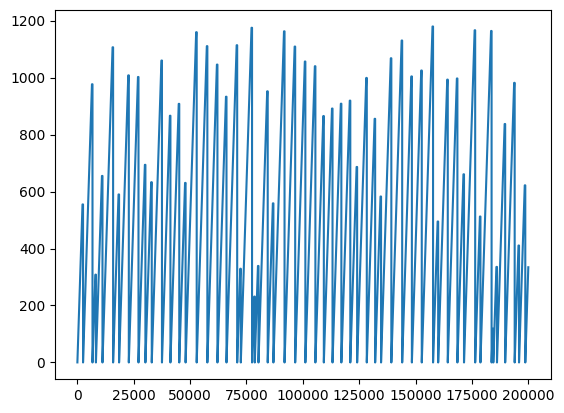

In [17]:
sns.lineplot(x=np.arange(200000), y=status[:, 2])